In [1]:
import numpy as np
import keras
import tensorflow as tf

# Loading train, val, and test datasets
train_dataset = keras.utils.image_dataset_from_directory(
    "/kaggle/input/knee-osteoarthritis-dataset-with-severity/train",
    image_size=(128, 128),
    batch_size=32
)

val_dataset = keras.utils.image_dataset_from_directory(
    "/kaggle/input/knee-osteoarthritis-dataset-with-severity/val",
    image_size=(128, 128),
    batch_size=32
)

test_dataset = keras.utils.image_dataset_from_directory(
    "/kaggle/input/knee-osteoarthritis-dataset-with-severity/test",
    image_size=(128, 128),
    batch_size=32
)

# Normalizing datasets
normalization_layer = keras.layers.Rescaling(1./255)
train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
val_dataset = val_dataset.map(lambda x, y: (normalization_layer(x), y))
test_dataset = test_dataset.map(lambda x, y: (normalization_layer(x), y))

# Function to convert dataset to lists of negative images and labels
def process_dataset(dataset):
    images = []
    labels = []
    for imgs, lbls in dataset:
        for img, lbl in zip(imgs, lbls):
            img = tf.image.rgb_to_grayscale(img)
            img = img.numpy()
            negative_img = 1 - img
            images.append(negative_img)
            labels.append(lbl.numpy())
    return np.array(images), np.array(labels)

# Processing the datasets
train_images, train_labels = process_dataset(train_dataset)
val_images, val_labels = process_dataset(val_dataset)
test_images, test_labels = process_dataset(test_dataset)

# Converting labels to one-hot encoded format
train_labels = keras.utils.to_categorical(train_labels, 5)
val_labels = keras.utils.to_categorical(val_labels, 5)
test_labels = keras.utils.to_categorical(test_labels, 5)

# Check the shapes of the datasets
print(f"Train images shape: {train_images.shape}")
print(f"Train labels shape: {train_labels.shape}")
print(f"Validation images shape: {val_images.shape}")
print(f"Validation labels shape: {val_labels.shape}")
print(f"Test images shape: {test_images.shape}")
print(f"Test labels shape: {test_labels.shape}")


2024-06-16 04:26:30.409384: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-16 04:26:30.409482: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-16 04:26:30.537087: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Found 5778 files belonging to 5 classes.
Found 826 files belonging to 5 classes.
Found 1656 files belonging to 5 classes.
Train images shape: (5778, 128, 128, 1)
Train labels shape: (5778, 5)
Validation images shape: (826, 128, 128, 1)
Validation labels shape: (826, 5)
Test images shape: (1656, 128, 128, 1)
Test labels shape: (1656, 5)


In [2]:
#combining into one

images = np.concatenate((train_images, val_images, test_images), axis=0)
labels = np.concatenate((train_labels, val_labels, test_labels), axis=0)

images.shape

(8260, 128, 128, 1)

In [3]:
from keras.models import Sequential 
from keras.layers import Dense, Dropout, GlobalAvgPool2D, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D 
from keras.callbacks import ModelCheckpoint 

model = Sequential()

#first cnn layers followed by a relu and a max pooling layer
model.add(Conv2D(64, (3,3), padding = 'same', input_shape = (128, 128, 1), activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

#second layer similarly
model.add(Conv2D(64, (3,3), padding = 'same', activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

#third layer
model.add(Conv2D(64, (3,3), padding = 'same', activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

#brings everything to a simple shape, basically (128,1)
model.add(GlobalAvgPool2D())

model.add(Dense(1024, activation='relu'))

#final layer
model.add(Dense(5,activation='softmax'))

model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         5,125 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 146,949 (574.02 KB)

 Trainable params: 146,565 (572.52 KB)

 Non-trainable params: 384 (1.50 KB)

In [4]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.1)

In [5]:
from keras.callbacks import ModelCheckpoint

model_checkpoint = ModelCheckpoint('model.keras', monitor='val_accuracy', save_best_only=True, verbose=1, mode='max')

In [6]:
history=model.fit(x_train,y_train,epochs=75,validation_split=0.2, batch_size=40,callbacks=[model_checkpoint])

Epoch 1/75
  7/149 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.2644 - loss: 1.5503

I0000 00:00:1718512039.785344     128 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1718512039.805165     128 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.3631 - loss: 1.4462

W0000 00:00:1718512048.629996     130 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1718512049.594612     128 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_accuracy improved from -inf to 0.25824, saving model to model.keras
149/149 ━━━━━━━━━━━━━━━━━━━━ 21s 75ms/step - accuracy: 0.3632 - loss: 1.4461 - val_accuracy: 0.2582 - val_loss: 1.6645
Epoch 2/75
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.3872 - loss: 1.4107
Epoch 2: val_accuracy did not improve from 0.25824
149/149 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.3872 - loss: 1.4106 - val_accuracy: 0.1305 - val_loss: 1.6405
Epoch 3/75
147/149 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.3998 - loss: 1.3953
Epoch 3: val_accuracy improved from 0.25824 to 0.27102, saving model to model.keras
149/149 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.3998 - loss: 1.3952 - val_accuracy: 0.2710 - val_loss: 1.7419
Epoch 4/75
147/149 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.3927 - loss: 1.3856
Epoch 4: val_accuracy did not improve from 0.27102
149/149 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.3927 - loss: 1.3855 - val_accuracy: 0.2670 - val_loss: 1.563

In [7]:
model.save('model.keras')

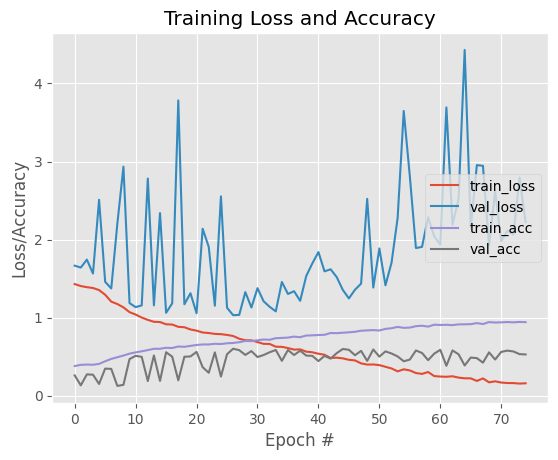

In [8]:
from matplotlib import pyplot as plt

# Assuming 'history' is the variable holding the training history object
N = len(history.history["loss"])  # Dynamically set N to match the number of epochs

# Plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="center right")
plt.savefig("CNN_Model.png")  # Save the plot as a PNG file
plt.show()  # Display the plot


### Prediction

In [ ]:
# X = 32
# img_size = 128
# img_single = x_test[X]
# img_single = cv2.resize(img_single, (img_size, img_size))
# img_single = (np.expand_dims(img_single, 0))
# img_single = img_single.reshape(img_single.shape[0],256,256,1)

# predictions_single = model.predict(img_single)
# print('A.I predicts:',categories[np.argmax(predictions_single)])
# print("Correct prediction for label",np.argmax(y_test[X]),'is',categories[np.argmax(y_test[X])])
# plt.imshow(np.squeeze(img_single))
# plt.grid(False)
# plt.show()

### Confusion Matrix

16/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

W0000 00:00:1718512354.516577     129 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step


W0000 00:00:1718512356.254444     129 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


<Figure size 640x480 with 0 Axes>

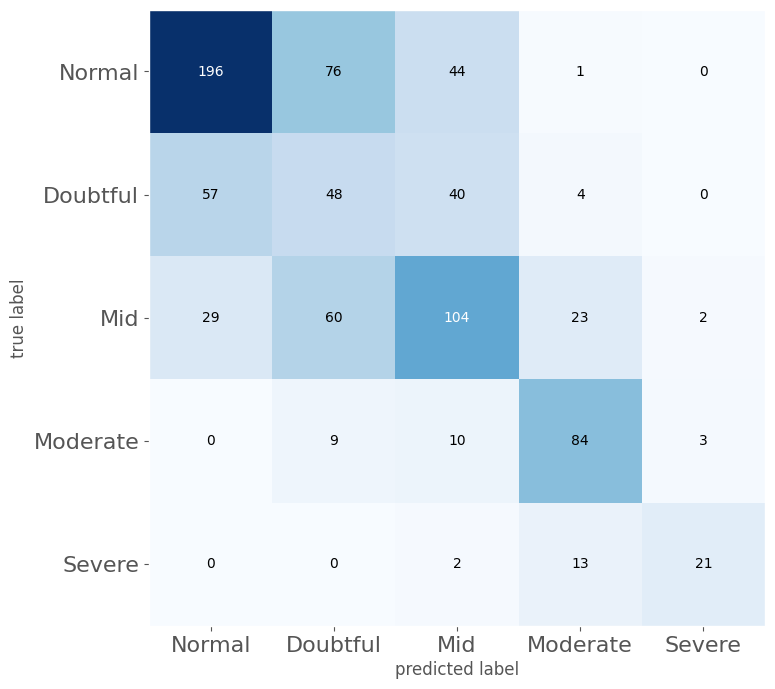

In [9]:
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

test_labels = np.argmax(y_test, axis=1)
predictions = model.predict(x_test)
predictions = np.argmax(predictions, axis=-1)

cm  = confusion_matrix(test_labels, predictions)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True,cmap=plt.cm.Blues)
plt.xticks(range(5), ['Normal','Doubtful','Mid','Moderate','Severe'], fontsize=16)
plt.yticks(range(5), ['Normal','Doubtful','Mid','Moderate','Severe'], fontsize=16)
plt.show()